In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time
from ggplot import *

<h2>Access Data</h2>

In [2]:
df = pd.read_csv("heart.csv",na_values='?')

In [3]:
print(len(df))
df = df.dropna()
print(len(df))

303
297


</h3>The original dataset had 303 rows. Six rows were deleted using listwise reduction, reducing it to 297. </h3>

In [6]:
df.columns.values

array(['Patient', 'Age', 'Sex', 'CP', 'Trestbps', 'Chol', 'Fbs', 'Restecg',
       'Thalach', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'Num'], dtype=object)

<h3>Attribute Types:</h3>

</h3>1. Discrete Numeric</h3>

In [7]:
age = df.ix[:,'Age']
trestbps = df.ix[:,'Trestbps']
chol = df.ix[:,'Chol']
thalach = df.ix[:,'Thalach']

</h3>2. Continuous Numeric </h3>

In [8]:
oldpeak = df.ix[:,'Oldpeak']

</h3>3. Nominal Categorical (dichotomous)</h3>

In [9]:
sex = df.ix[:,'Sex']
fbs = df.ix[:,'Fbs']
exang = df.ix[:,'Exang']

</h3>4. Nominal Categorical (non-dichotomous) </h3>

In [10]:
cp = pd.get_dummies(df.ix[:,'CP'], prefix = 'cp')
restecg = pd.get_dummies(df.ix[:,'Restecg'], prefix = 'r')
slope = pd.get_dummies(df.ix[:,'Slope'], prefix = 'slope')
thal = pd.get_dummies(df.ix[:,'Thal'], prefix = 'thal')

</h3>In order to use non-dichotomous categorical data, dummy variables were assigned to each outcome. </h3>

In [11]:
clean_data = pd.concat([age, sex, fbs, exang, trestbps, chol, thalach, oldpeak, cp, restecg, slope, thal], axis=1)

</h3>Convert target values to binary from {0,1,2,3,4} - Assignment requirement </h3>

In [12]:
total_num = df.ix[:,'Num']
adj_target = []
for i in total_num:
	if i == 0:
		adj_target.append(0)
	else:
		adj_target.append(1)
target = pd.Series(adj_target)

<h3>Dimensionality Reduction</h3>

In [13]:
X = clean_data.ix[:,:]
Y = target
names = clean_data.columns.values

In [14]:
rlasso = RandomizedLasso(alpha=0.01)
rlasso.fit(X, Y)
print "Features sorted by their score: (Stability Selection)"
stable = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), names), reverse=True)
print stable

Features sorted by their score: (Stability Selection)
[(0.505, 'thal_3.0'), (0.475, 'cp_4'), (0.4, 'Thalach'), (0.325, 'Oldpeak'), (0.28, 'thal_7.0'), (0.265, 'Exang'), (0.085, 'slope_1'), (0.02, 'slope_2'), (0.0, 'thal_6.0'), (0.0, 'slope_3'), (0.0, 'r_2'), (0.0, 'r_1'), (0.0, 'r_0'), (0.0, 'cp_3'), (0.0, 'cp_2'), (0.0, 'cp_1'), (0.0, 'Trestbps'), (0.0, 'Sex'), (0.0, 'Fbs'), (0.0, 'Chol'), (0.0, 'Age')]


In [15]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)
print "Features sorted by their rank: (RFE)"
rfe = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))
print rfe

Features sorted by their rank: (RFE)
[(1.0, 'thal_3.0'), (2.0, 'cp_4'), (3.0, 'slope_2'), (4.0, 'Exang'), (5.0, 'Sex'), (6.0, 'thal_7.0'), (7.0, 'r_0'), (8.0, 'Oldpeak'), (9.0, 'cp_1'), (10.0, 'r_1'), (11.0, 'cp_3'), (12.0, 'slope_3'), (13.0, 'slope_1'), (14.0, 'r_2'), (15.0, 'Age'), (16.0, 'Fbs'), (17.0, 'thal_6.0'), (18.0, 'Thalach'), (19.0, 'cp_2'), (20.0, 'Trestbps'), (21.0, 'Chol')]


</h3>Reduced datasets from both algorithms:</h3>

In [16]:
lr_data = pd.concat([clean_data['cp_4'],clean_data['thal_3.0'],clean_data['Thalach'],clean_data['Oldpeak'],clean_data['thal_7.0'],clean_data['Exang']],axis=1)
rfe_data = pd.concat([clean_data['thal_3.0'],clean_data['cp_4'],clean_data['slope_2'],clean_data['Exang'],clean_data['Sex']],axis=1)

</h3>Set training and testing data.</h3>

In [18]:
#Train
train_data = clean_data.ix[:24,:]
train_lr_data = lr_data.ix[:24,:]
train_rfe_data = rfe_data.ix[:24,:]
train_nums = target.ix[:24]

#Test
test_data = clean_data.ix[25:,:]
test_lr_data = lr_data.ix[25:,:]
test_rfe_data = rfe_data.ix[25:,:]
test_target = target.ix[25:]

<h3>Logistic Regression</h3>

In [19]:
llr = LogisticRegression()
llr.fit(train_data,train_nums)
all_lr = llr.score(test_data,test_target)
all_log = (all_lr)*100
print "Using all attributes classfied " + "{0:0.2f}".format(all_log) + "% of all values correctly."

llr1 = LogisticRegression()
llr1.fit(train_lr_data,train_nums)
lr_lr = llr1.score(test_lr_data,test_target)
lr_log = (lr_lr)*100
print "Using stability selection attributes classfied " + "{0:0.2f}".format(lr_log) + "% of all values correctly."

llr2 = LogisticRegression()
llr2.fit(train_rfe_data,train_nums)
rfe_lr = llr2.score(test_rfe_data,test_target)
rfe_log = (rfe_lr)*100
print "Using rfe attributes classfied " + "{0:0.2f}".format(rfe_log) + "% of all values correctly."

Using all attributes classfied 76.10% of all values correctly.
Using stability selection attributes classfied 78.31% of all values correctly.
Using rfe attributes classfied 82.35% of all values correctly.


<h3>5-fold cross validation</h3>

In [20]:
scores_all_lr = cross_validation.cross_val_score(llr, clean_data, target, cv=5)
scores_ss_lr = cross_validation.cross_val_score(llr1, lr_data, target, cv=5)
scores_rfe_lr = cross_validation.cross_val_score(llr2, rfe_data, target, cv=5)
print "Accuracy of complete dataset: " + "{0:0.2f}".format(scores_all_lr.mean()*100) +"%"
print "Accuracy of Stability selection attributes: " + "{0:0.2f}".format(scores_ss_lr.mean()*100) +"%"
print "Accuracy of rfe attributes: " + "{0:0.2f}".format(scores_rfe_lr.mean()*100) +"%"

Accuracy of complete dataset: 81.12%
Accuracy of Stability selection attributes: 81.80%
Accuracy of rfe attributes: 82.49%


<h3>ROC Curve: RFE reduced data </h3>

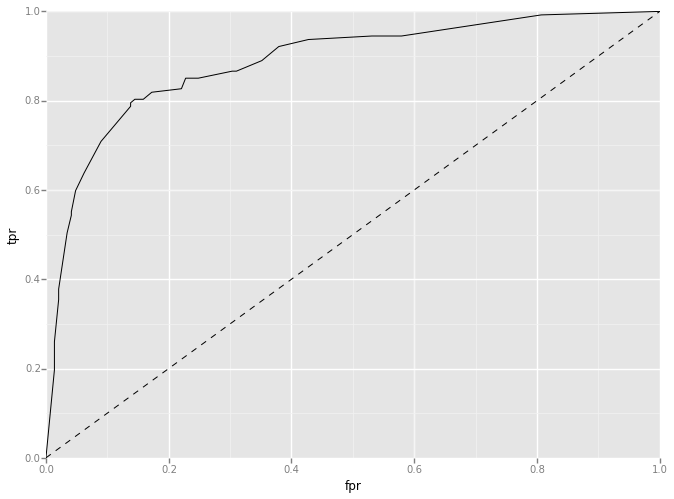

<ggplot: (292913481)>

In [27]:
%matplotlib inline
from ggplot import *
def roc_curve(data):
	Xtrain = data[0:24]
	Xtest = data[25:]
	ytrain = target[0:24]
	ytest = target[25:]

	clf = LogisticRegression()
	clf.fit(Xtrain, ytrain)

	preds = clf.predict_proba(Xtest)[:,1]
	fpr, tpr, _ = metrics.roc_curve(ytest, preds)
	df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
	return ggplot(df, aes(x='fpr', y='tpr')) +\
  		geom_line() +\
    	geom_abline(linetype='dashed')
roc_curve(rfe_data)


<h3>Area under curve: RFE reduced data</h3>

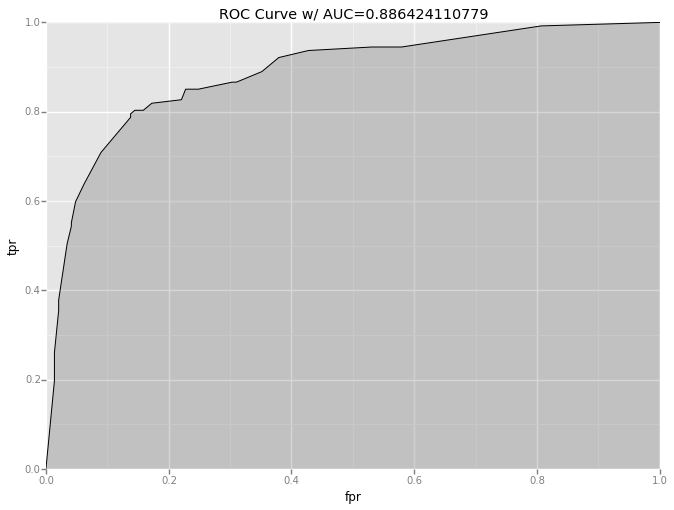

<ggplot: (292881125)>

In [28]:
def auc(data):
	Xtrain = data[0:24]
	Xtest = data[25:]
	ytrain = target[0:24]
	ytest = target[25:]

	clf = LogisticRegression()
	clf.fit(Xtrain, ytrain)

	preds = clf.predict_proba(Xtest)[:,1]
	fpr, tpr, _ = metrics.roc_curve(ytest, preds)
	df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
	auc = metrics.auc(fpr,tpr)
	return ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) +\
    	   		geom_area(alpha=0.2) +\
    			geom_line(aes(y='tpr')) +\
    			ggtitle("ROC Curve w/ AUC=%s" % str(auc))
auc(rfe_data)